In [1]:
import os
import pandas as pd 
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import json
import joblib

from scipy.stats import loguniform

from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, roc_curve, roc_auc_score, auc

In [2]:
df = pd.read_csv("lead_data_expanded.csv")
df.columns


Index(['School_District', 'School', 'County', 'num_lte_5ppb', 'num_gt_5ppb',
       'School_City', 'Ratio_free', 'Student_teacher_ratio',
       'American_Indian/Alaska_Native', 'Asian', 'Black', 'Hispanic', 'White',
       'Native_Hawaiian/Pacific_Islander', 'Two_or_More_Races', 'target_col',
       'percent_housing_pre_1950'],
      dtype='object')

In [3]:
df_copied = df.copy()

### Train test split

In [4]:
X = df_copied.drop(columns=['target_col','num_gt_5ppb','School', 'num_lte_5ppb', 'County']) 
y = df_copied['target_col']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=40, stratify=y,)
X_train_t, X_train_v, y_train_t, y_train_v = train_test_split(X_train, y_train, test_size=0.2, random_state=40, stratify=y_train)

In [6]:
X.columns

Index(['School_District', 'School_City', 'Ratio_free', 'Student_teacher_ratio',
       'American_Indian/Alaska_Native', 'Asian', 'Black', 'Hispanic', 'White',
       'Native_Hawaiian/Pacific_Islander', 'Two_or_More_Races',
       'percent_housing_pre_1950'],
      dtype='object')

In [7]:
num_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

### Pipeline

In [8]:
num_transformer = Pipeline([('imputer',SimpleImputer(strategy='median')), ('scaler',StandardScaler())])
cat_transformer = Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),('onehot',OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([('num',num_transformer,num_features),('cat', cat_transformer,cat_features)])

## SVC Model with Hyperparameter Tuning

In [9]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=40, stratify=y,)

In [15]:
# parameter distributions
param_distributions = {
    'classifier__C': loguniform(1e-3, 1e3),       # C ~ logunif[0.001, 1000]
    'classifier__gamma': loguniform(1e-4, 1e1),   # gamma ~ logunif[0.0001, 10]
    'classifier__kernel': ['linear', 'rbf']       # don't include poly to avoid overfitting
}

# model
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=40))
])

# for storing data
outer_cv = KFold(n_splits=5, shuffle=True, random_state=40)
nested_scores = []
inner_cv_scores = []
best_parameters = []
roc_curves = []

# to store true and predicted values across outer fold
y_true_all = []
y_pred_all = []



In [16]:
# nested cross validation
for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X), start=1):
    X_outer_train, X_outer_test = X.iloc[train_idx], X.iloc[test_idx]
    y_outer_train, y_outer_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # inner cv for hyperparameter tuning
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=40)
    inner_search = RandomizedSearchCV(
        clf,
        param_distributions,
        n_iter=100, 
        cv=inner_cv,
        scoring='roc_auc',
        random_state=40,
        n_jobs=-1
    )
    inner_search.fit(X_outer_train, y_outer_train)

    inner_cv_scores.append(float(inner_search.best_score_))

    
    # Evaluate best model on outer test fold
    best_inner_model = clone(inner_search.best_estimator_)
    best_inner_model.fit(X_outer_train, y_outer_train)
    y_pred_outer = best_inner_model.predict(X_outer_test)
    roc = roc_auc_score(y_outer_test, y_pred_outer)

    # store the best parameters from each inner CV
    best_parameters.append(inner_search.best_params_)

    # store data
    nested_scores.append(roc)
    y_true_all.extend(y_outer_test)
    y_pred_all.extend(y_pred_outer)

    # Compute ROC curve
    y_score_outer = best_inner_model.decision_function(X_outer_test)
    fpr, tpr, _ = roc_curve(y_outer_test, y_score_outer)
    roc_curves.append((fpr,tpr))


# Print Accuracies and Best Parameters
print("Inner fold ROC scores:", inner_cv_scores)
print("Outer fold ROC scores:", nested_scores)
print("Mean ROC scores:", np.mean(nested_scores))
print(f"Fold {fold_idx}), Best Parameters: {best_parameters}, ROC-AUC: {roc:0.4f}")

Inner fold ROC scores: [0.7620435734419065, 0.7552418823028547, 0.7523236397122858, 0.768386006580529, 0.7492831711195646]
Outer fold ROC scores: [0.7315178738536403, 0.7206605680371059, 0.7393468173284687, 0.7388138765612308, 0.7613772878241821]
Mean ROC scores: 0.7383432847209256
Fold 5), Best Parameters: [{'classifier__C': np.float64(484.4210218943532), 'classifier__gamma': np.float64(0.029745467430089757), 'classifier__kernel': 'linear'}, {'classifier__C': np.float64(484.4210218943532), 'classifier__gamma': np.float64(0.029745467430089757), 'classifier__kernel': 'linear'}, {'classifier__C': np.float64(30.70083010111321), 'classifier__gamma': np.float64(0.001724714560502212), 'classifier__kernel': 'linear'}, {'classifier__C': np.float64(0.5108167033122747), 'classifier__gamma': np.float64(0.04423519926265442), 'classifier__kernel': 'linear'}, {'classifier__C': np.float64(50.196157625753926), 'classifier__gamma': np.float64(0.010451890348066777), 'classifier__kernel': 'rbf'}], ROC-AU

### ROC Curves

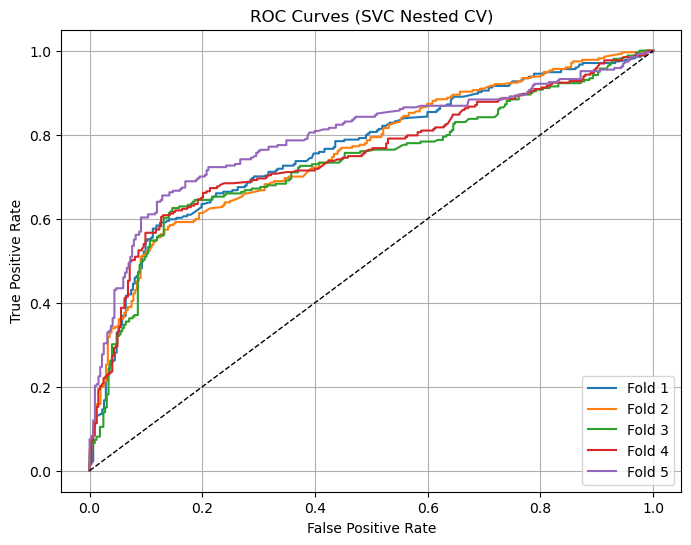

In [17]:
# Plot ROC curves for all folds
plt.figure(figsize=(8,6))
for i, (fpr, tpr) in enumerate(roc_curves, 1):
    plt.plot(fpr, tpr, label=f'Fold {i}')
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (SVC Nested CV)')
plt.legend(loc='lower right')
plt.grid()
plt.show()